## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [2]:
pip install odc-geo --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster, create_dask_gateway_cluster
from coastlines.raster import model_tides, multiprocess_apply
from intertidal.extents import load_data, pixel_tide_sort, item, nidem


def create_dask_gateway_cluster(profile="r5_L", workers=2):
    """
    Create a cluster in our internal dask cluster.
    Parameters
    ----------
    profile : str
        Possible values are:
            - r5_L (2 cores, 15GB memory)
            - r5_XL (4 cores, 31GB memory)
            - r5_2XL (8 cores, 63GB memory)
            - r5_4XL (16 cores, 127GB memory)
    workers : int
        Number of workers in the cluster.
    """        
    
    try:
        
        from dask_gateway import Gateway
        gateway = Gateway()

        # Close any existing clusters
        if len(cluster_names) > 0:
            print("Cluster(s) still running:", cluster_names)
            for n in cluster_names:
                cluster = gateway.connect(n.name)
                cluster.shutdown()

        # Connect to new cluster
        options = gateway.cluster_options()
        options["profile"] = profile
        options["jupyterhub_user"] = "robbi"
        cluster = gateway.new_cluster(options)
        cluster.scale(workers)

        return cluster

    except ClientConnectionError:
        raise ConnectionError("Access to dask gateway cluster unauthorized")

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-rmud25mf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-rimudm55', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-efys71na', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-m_mysw2o', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-owituavz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-hc9couex', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/work

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46611,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:39743,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/43097/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:42367,


## Setup

In [5]:
dc = datacube.Datacube(app='Intertidal_elevation')

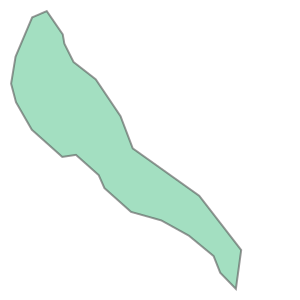

In [132]:
# aoi = 'McCarthur River'
# aoi = 'Greenbank'
# aoi = 'Seven Emu'
aoi = 'Wollogorang'

# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [12]:
# from odc.ui import select_on_a_map
# from ipyleaflet import basemaps, basemap_to_tiles

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height='600px',
#                              layers=(basemap,),
#                              center=(-26, 135), 
#                              zoom=4)

## Load data

In [133]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=('2017', '2021'), 
               resolution=10)
ds

<xarray.Dataset>
Dimensions:      (time: 720, y: 3413, x: 2930)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-14T00:47:04.662698 ... 2021-12...
  * y            (y) float64 8.199e+06 8.199e+06 ... 8.165e+06 8.165e+06
  * x            (x) float64 7.911e+05 7.911e+05 ... 8.204e+05 8.204e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Pixel-based tides

In [134]:
# Create a new 5km-res tide modelling grid after first
# buffering the grid by 12km (i.e. at least two 5km pixels)
rescaled_geobox = ds.odc.geobox.buffered(12000).zoom_out(500)
rescaled_ds = odc.geo.xr.xr_zeros(rescaled_geobox)

# Flatten grid to 1D, then add time dimension
flattened_ds = rescaled_ds.stack(z=("x", "y"))
flattened_ds = flattened_ds.expand_dims(dim={"time": ds.coords["time"].values})

In [135]:
# Model tides for each time and grid cell
tide_df = model_tides(
    x=flattened_ds.x,
    y=flattened_ds.y,
    time=flattened_ds.time,
    directory="~/tide_models",
    epsg=ds.odc.geobox.crs.epsg,
)

In [136]:
# Insert modelled tide values back into flattened array, then unstack
# back to 3D (x, y, time)
tides_ds = (
    flattened_ds.groupby("time")
    .apply(lambda x: tide_df.loc[str(x.time.values)].tide_m.values)
    .astype(np.float32)
    .unstack("z")
    .T
)

In [137]:
# Reproject each timestep into higher resolution, and add as new variable
def timestep_reproject(x, to_geobox=ds.odc.geobox):
    return x.odc.reproject(to_geobox, resampling='cubic')

ds['tide_m'] = multiprocess_apply(tides_ds, dim='time', func=timestep_reproject)


<AxesSubplot:title={'center':'time = 2017-01-21T00:53:13.103994, spatial_ref ...'}, xlabel='x', ylabel='y'>

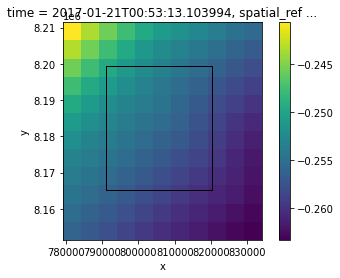

In [138]:
timestep = tides_ds.isel(time=1)
timestep.plot()
gpd.GeoSeries(ds.odc.geobox.footprint(crs='EPSG:32753').geom).plot(ax=plt.gca(), vmin=timestep.min(), vmax=timestep.max(), color='none')

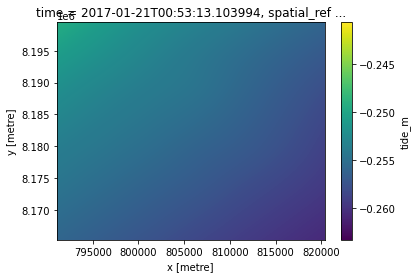

In [139]:
ds['tide_m'].isel(time=1).plot.imshow(vmin=timestep.min(), vmax=timestep.max())

## ITEM/NIDEM method

In [140]:
intervals=10

# Add tide height dimension
ds_item = ds.copy()
ds_item['tide_height'] = ds_item.tide_m.mean(dim=['x', 'y'])
ds_item = ds_item.swap_dims({"time": "tide_height"}).drop("time")

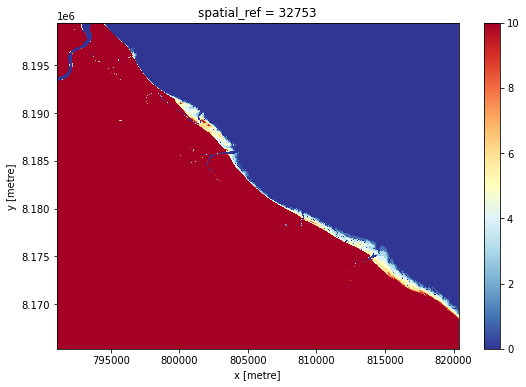

In [141]:
# Calculate intertidal extents
ds_item.persist()
item_da, ds_intervals, ds_confidence = item(ds_item, tide_dim='tide_height', intervals=intervals)
item_da.plot.imshow(cmap='RdYlBu_r', size=6)

In [108]:
# Convert ITEM to NIDEM elevations
intertidal_dem_clean = nidem(item_da, ds_intervals, intervals)
intertidal_dem_clean.plot.imshow(cmap='viridis', size=6)

In [107]:
# fname = 'testing'
fname = aoi.lower().replace(" ", "")

# Export as a GeoTIFF
intertidal_dem_clean.odc.write_cog(
    fname=f"data/interim/nidem_dem_{fname}.tif", overwrite=True
)
ds_confidence.ndwi.odc.write_cog(
    fname=f"data/interim/nidem_confidence_{fname}.tif", overwrite=True
)

PosixPath('data/interim/nidem_dem_mccarthurriver.tif')

## Pixel-based

### Special sorting

In [ ]:
# Load into memory
ds.load()

In [ ]:
# Sort each pixel by tide
ds = pixel_tide_sort(ds, tide_var='tide_m', ndwi_var='ndwi', tide_dim='tide_n')
ds.isel(tide_n=[5, -5]).ndwi.plot.imshow(col='tide_n', vmin=-0.25, vmax=0.25)

### Rolling median

In [ ]:
ds_rolling = ds.ndwi.rolling(tide_n=100, min_periods=10, center=True)
s2_median = ds_rolling.median()
s2_stdev = ds_rolling.std()
s2_stdev_mean = s2_stdev.mean(dim='tide_n')

### Elevation calculation

In [ ]:
# Output name
fname = 'testing'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
from dask_gateway import Gateway
gateway = Gateway()

# Close any existing clusters
cluster_names = gateway.list_clusters()
if len(cluster_names) > 0:
    print("Cluster(s) still running:", cluster_names)
    for n in cluster_names:
        cluster = gateway.connect(n.name)
        cluster.shutdown()

In [ ]:
cluster.shutdown()